# Examen ETL: SPARK 02/02

Se podrá utilizar toda la información que se encuentra en el campus. 

El fichero de datos sobre el que se trabajará es el de partidosLigaNBA.txt.

A cada una de las preguntas hay que responder explicando brevemente que se pretende hacer antes de lanzar el código.

Al documento lo llamareís con vuestro nombre y apellido. Debeís enviarlo a mi correo de CUNEF antes del final del examen.

El lenguaje para trabajar con Spark podrá ser python o R indistintamente.

In [1]:
from pyspark import SparkContext
sc = SparkContext()

In [2]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import datetime as dt
import re

In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

## 1. Parsear el dataset para su tratamiento (lo que hemos visto hasta ahora, lo necesario para poder usar la información que se nos pide)

In [4]:
datasource = "./partidosLigaNBA.csv"
NBA_data = sc.textFile(datasource)

In [5]:
NBA_data.take(5)

['Date:Start..ET.:Visitor.Neutral:PTS:Home.Neutral:PTS.1',
 'Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96',
 'Tue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93',
 'Tue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106',
 'Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74']

In [6]:
NBA_data.count()

12908

In [7]:
def parse_log2(line):
    match = re.search('^\S{3}..(\S{3}.\d+)..(\d{4}):.(\d+:\d{2}.\S+).:(\S+.\S*.\S*):(\d+):(\S+.\S*.\S*):(\d+)',line)
    if match is None:
        match = re.search('^\S{3}..(\S{3}.\d+)..(\d{4}):.(\d+:\d{2}.\S+).:(\S+.\S*.\S*):(\d+):(\S+.\S*.\S*):(\d+)',line)
    if match is None:
        return (line, 0)
    else:
        return (line, 1)

In [8]:
def map_log(line):
    match = re.search('^\S{3}..(\S{3}.\d+)..(\d{4}):.(\d+:\d{2}.\S+).:(\S+.\S*.\S*):(\d+):(\S+.\S*.\S*):(\d+)',line)
    if match is None:
        match = re.search('^\S{3}..(\S{3}.\d+)..(\d{4}):.(\d+:\d{2}.\S+).:(\S+.\S*.\S*):(\d+):(\S+.\S*.\S*):(\d+)',line)
    return(match.groups())

In [9]:
raw_data = NBA_data.filter(lambda x: "PTS" not in x).filter(lambda x: "Playoffs" not in x)
parsed_rdd = raw_data.map(lambda line: parse_log2(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
NBA_parsed = parsed_rdd.map(lambda line: map_log(line))

In [10]:
NBA_parsed.take(1)

[('Oct 30',
  '2007',
  '7:30 pm',
  'Utah Jazz',
  '117',
  'Golden State Warriors',
  '96')]

In [11]:
NBA_parsed.count()

12897

## 2. Breve análisis descriptivo para analizar si el dataset está límpio

In [12]:
import numpy as np

def parse_interaction(line):
    symbolic_indexes = [0,1,2,3,5]
    clean_line_split = [item for i,item in enumerate(line) if i not in symbolic_indexes]
    return np.array([float(x) for x in clean_line_split])

vector_data = NBA_parsed.map(lambda line: parse_interaction(line))
vector_data.take(5)

[array([ 117.,   96.]),
 array([ 95.,  93.]),
 array([  97.,  106.]),
 array([ 92.,  74.]),
 array([ 103.,  120.])]

In [13]:
from pyspark.mllib.stat import Statistics 
from math import sqrt 

# Compute column summary statistics.
summary = Statistics.colStats(vector_data)

print("Estadisticas de Puntos Locales:")
print(" Media: {}".format(summary.mean()[0]))
print(" Desviacion Estandar: {}".format(sqrt(summary.variance()[0])))
print(" Max valor: {}".format(summary.max()[0]))
print(" Min valor: {}".format(summary.min()[0]))
print(" Total numero: {}".format(summary.count()))
print(" Numero de valores no cero: {}".format(summary.numNonzeros()[0]))

Estadisticas de Puntos Locales:
 Media: 98.73520973869864
 Desviacion Estandar: 12.126698613648237
 Max valor: 154.0
 Min valor: 54.0
 Total numero: 12897
 Numero de valores no cero: 12897.0


In [14]:
print("Estadisticas de Puntos Visitas:")
print(" Media: {}".format(summary.mean()[1]))
print(" Desviacion Estandar: {}".format(sqrt(summary.variance()[1])))
print(" Max valor: {}".format(summary.max()[1]))
print(" Min valor: {}".format(summary.min()[1]))
print(" Total numero: {}".format(summary.count()))
print(" Numero de valores no cero: {}".format(summary.numNonzeros()[1]))

Estadisticas de Puntos Visitas:
 Media: 101.77801039001278
 Desviacion Estandar: 12.26352447498637
 Max valor: 168.0
 Min valor: 59.0
 Total numero: 12897
 Numero de valores no cero: 12897.0


## 3. Enunciado

### 3.1. Primera pregunta: Describe brevemente que diferencia el persists, cache y collect en spark. Explica brevemente casos en los que es interesante su aplicación

La persistencia es una técnica de optimización en la que se guarda el resultado intermedio para usarlo si es necesario, ésto permite que no se soobrecargue el sistema.
En cuanto a las diferencias entre cache() y persist(), es que el primero (cache) solo se almacena en memoria (almacenamiento predeterminado es MEMORY_ONLY). Mientras que persist tiene varios niveles de almacenamiento (MEMORY_ONLY, MEMORY_AND_DISK, MEMORY_ONLY_SER, MEMORY_AND_DISK_SER y DISK_ONLY).
En cambio, Collect es una acción que trae los elementos del RDD al programa driver.
Por ejemplo, se puede especificar que en un entorno de Spark, se usa cache para los calculos (se guardan en memoria), y en la aplicación del Spark "RDD.take(10)" es que se traen los 10 primeros registros.

### 3.2. Segunda pregunta: Explica brevemente los pasos a seguir para realizar la carga de un conjunto de datos (pasos que se siguieron en la práctica con datos de logs)

* a. Se crea el Contexto Spark donde se va a trabajar.

* b. Se crea la asociación del contexto con el archivo a través de la operación TextFile.

* c. Mediante el uso del package re, se parsea las lineas del archivo con expresiones regulares para determinar las columnas.

* d. También se pueden utilizar funciones de conversión de número y fecha.

* e. Con el uso de un sqlContext, se puede trabajar el RDD como si fuera un dataframe. Para ello se tiene que definir el schema, y como los datos ya estan parseados se pueden pasar con un formato limpio. Esta manera de utilizar SQLContexto nos entrega más flexibilidad para revisar los datos.

### 3.3. Tercera Pregunta: Índica un tipo de problema que puede empeorar los datos. (pe. Que no exista un representante del CDO en todas las áreas de negocio), pon algún ejemplo específico (pe. Datos duplicados) y cómo lo tratarías con técnicas de data cleaning.

El problema principal, como indica el enunciado, es la duplicidad de datos, la gestión de cada área es independiente y ésto hace que no se estandarice los fórmatos de la información como también puede existir detalles no contemplados en otras área (pe. Un área prefiere manejar la información a nivel de semanas, y otra diaria). Un posible cruce de información sería complicado de realizar.

La primera actividad es trabajar con levantamiento de información. Teniendo en cuenta los requerimientos y casos de negocio realizar los prototipos de tablas maestras y tablas detalle. Desarrollar los procesos de extracción de las fuentes. Después, en la etapa de procesamiento, comenzar a hacer los links de las fuentes extraidas y como manejarla (puede ser mediante expresiones regulares y, transformaciones y acciones RD o mediante SQL Context, ésto depende de la complejidad del procesamiento). Finalmente con la información limpia se pueden cargar a las tablas finales (o archivos si se requiere).

### 3.4. Cuarta tarea: Inicializar spark context y cargar los datos desde el fichero.

La solución de ésta pregunta se encuentra en el apartado 1. Parsear el dataset para su tratamiento (lo que hemos visto hasta ahora, lo necesario para poder usar la información que se nos pide).
Se utiliza el RDD.

### 3.5. Quinta tarea: Media de la diferencia de puntos por año

In [15]:
import pandas as pd

In [16]:
NBA_dif_uniq = NBA_parsed.map(lambda line: (line[1],(int(line[4])-int(line[6])))).reduceByKey(lambda a, b: a + b)

NBA_dif_len = NBA_parsed.map(lambda line:  (line[1],line[0])).groupByKey().mapValues(len)
#length cuantas peticiones hay en total dado que solo se tiene data de un dia
joined = NBA_dif_len.join(NBA_dif_uniq).map(lambda a: (a[0], (a[1][1])/(a[1][0]))).collect()
#joined calcula la media de peticiones de cada dia (num peticiones/num hosts)
year = [x[0] for x in joined]
mean = [x[1] for x in joined]
year_dif_dct = {'Año':year, 'Media':mean}
year_dif_pt = pd.DataFrame(year_dif_dct)

In [17]:
year_dif_pt.sort_values('Año', ascending = True)

,Año,Media
6,2007,-2.728070
5,2008,-3.527027
8,2009,-3.628419
9,2010,-2.934141
3,2011,-3.056497
10,2012,-3.111262
1,2013,-2.778701
4,2014,-2.598951
7,2015,-2.568613
2,2016,-3.184546


### 3.6. Sexta tarea: ¿Han judado todos los equipos el mismo número de partidos? ¿ Si es qué no a que puede deberse?

In [18]:
NBA_loc_pl = NBA_parsed.map(lambda line:  (line[3],line[0])).groupByKey().mapValues(len)
NBA_vis_pl = NBA_parsed.map(lambda line:  (line[5],line[0])).groupByKey().mapValues(len)
#length cuantas peticiones hay en total dado que solo se tiene data de un dia
joined = NBA_loc_pl.join(NBA_vis_pl).map(lambda a: (a[0], (a[1][1])+(a[1][0]))).collect()
#joined calcula la media de peticiones de cada dia (num peticiones/num hosts)
team = [x[0] for x in joined]
count = [x[1] for x in joined]
NBA_tm_dct = {'Equipo':team, 'Nro Partidos':count}
NBA_tm_pls = pd.DataFrame(NBA_tm_dct)

In [19]:
NBA_tm_pls.sort_values('Nro Partidos', ascending = False)

,Equipo,Nro Partidos
7,San Antonio Spurs,933
28,Boston Celtics,930
22,Miami Heat,917
17,Cleveland Cavaliers,901
11,Los Angeles Lakers,897
29,Atlanta Hawks,896
4,Golden State Warriors,885
19,Chicago Bulls,873
13,Houston Rockets,868
12,Indiana Pacers,868


### 3.7. Séptima pregunta: ¿Cuantos partidos ha ganado en Enero Clevelant?

In [20]:
def get_win(line,ind):
    local_pt = int(line[4])
    vis_pt = int(line[6])
    if local_pt > vis_pt:
        return(line[3],line[ind])
    else:
        return(line[5],line[ind])

In [21]:
NBA_parsed.map(lambda line: get_win(line,0)).filter(lambda x: ("Jan" in x[1]) and ("Clevelan" in x[0])).count()

83

### 3.8. Octava pregunta: ¿Los Warrios son mejores fuera de casa o en casa?

In [22]:
def get_win2(line):
    local_pt = int(line[4])
    vis_pt = int(line[6])
    if local_pt > vis_pt:
        return('local',line[3])
    else:
        return('visita',line[5])

In [23]:
Warriors_win = NBA_parsed.map(lambda line: get_win2(line)).filter(lambda x: ("Warriors" in x[1])).groupByKey().mapValues(len)
Warriors_win.takeOrdered(1, lambda x: -x[1])

[('visita', 308)]

### 3.9. Novena pregunta: Equipo que ha quedado primerio en victorias más temporadas. (si es que hay alguno que más)

In [24]:
def get_winner(year,lmatches):
    matches = sorted(lmatches,reverse=True)
    return(year,matches[0])

In [25]:
Team_winners = NBA_parsed.map(lambda line: get_win(line,1)).map(lambda x: (x,1)).groupByKey().mapValues(len)
Temp_winners = Team_winners.map(lambda x: (x[0][1],x[1])).groupByKey().map(lambda x : [x[0],list(x[1])]).map(lambda line: get_winner(line[0],line[-1]))
Winners= Team_winners.map(lambda x: (x[0][1],(x[-1],x[0][0]))).join(Temp_winners.map(lambda y: (y[0],y[1]))).map(lambda line: (line[1][0][-1],line[0],line[1][0][0],line[1][1])).filter(lambda z: z[-2]==z[-1]).map(lambda line: (line[0],(line))).groupByKey().mapValues(len).collect()

In [26]:
team = [x[0] for x in Winners]
temp = [x[1] for x in Winners]
vic_count_dct = {'Equipo':team, 'Nro Temp':temp}
vic_count_df = pd.DataFrame(vic_count_dct)

In [27]:
vic_count_df.sort_values('Nro Temp', ascending = False)[:10]

,Equipo,Nro Temp
5,Golden State Warriors,3
1,San Antonio Spurs,2
3,Los Angeles Lakers,2
4,Boston Celtics,2
0,Miami Heat,1
2,Chicago Bulls,1


###  3.10. Décima pregunta: Escribe la expresión regular correcta que sólo macheen los teléfonos y el correo del siguiente texto.

Si eres cliente y necesitas información sobre tus posiciones, productos o realizar operaciones: Desde España. Desde el extranjero. Banca telefónica en castellano. Bandera castellano. 902 13 23 13. Banca telefónica en catalán. Bandera catalana. 902 88 30 08. Banca telefónica en inglés. Bandera inglesa. 902 88 88 35. O por correo electrónico a atencioncliente@bankinter.com

In [28]:
testStr = "Si eres cliente y necesitas información sobre tus posiciones, productos o realizar operaciones: Desde España. Desde el extranjero. Banca telefónica en castellano. Bandera castellano. 902 13 23 13. Banca telefónica en catalán. Bandera catalana. 902 88 30 08. Banca telefónica en inglés. Bandera inglesa. 902 88 88 35. O por correo electrónico a atencioncliente@bankinter.com"

In [29]:
rtelefono = '(\d{3} \d{2} \d{2} \d{2}).'
rcorreo = '\S+@\S+'
correo = re.search(rcorreo, testStr)
correo = correo.group()
telefonos = re.findall(rtelefono, testStr)
telefonos.append(correo)
telefonos

['902 13 23 13',
 '902 88 30 08',
 '902 88 88 35',
 'atencioncliente@bankinter.com']

In [30]:
#Otra manera con una sola expresion regular.
regexp ='(\d{3} \d{2} \d{2} \d{2}). \S+ \S+ \S+ \S+ \S+ \S+.(\d{3} \d{2} \d{2} \d{2}). \S+ \S+ \S+ \S+ \S+ \S+.(\d{3} \d{2} \d{2} \d{2}). \S+ \S+ \S+ \S+ \S+ (\S+@\S+)'
datos = re.search(regexp, testStr)
datos.groups()

('902 13 23 13',
 '902 88 30 08',
 '902 88 88 35',
 'atencioncliente@bankinter.com')

## 4. Generar histograma de los puntos anotados por los visitantes (este último punto será para la semana siguiente)

In [31]:
csv_data = NBA_parsed
row_data = csv_data.map(lambda p: Row(
    date=p[0], 
    year=p[1],
    hour=p[2],
    localTeam=p[3],
    localPts=int(p[4]),
    visitTeam=p[5],
    visitPts=int(p[6]),
    )
)
NBA_df = sqlContext.createDataFrame(row_data)
NBA_df.registerTempTable("NBALeague")

In [32]:
#Histograma de puntos visitantes
minValue = summary.min()[1]
meanValue = summary.mean()[1]
maxValue = summary.max()[1]

In [33]:
NBA_df = NBA_df.select("year","visitTeam","visitPts")
NBA_df.show(5)

+----+--------------------+--------+
|year|           visitTeam|visitPts|
+----+--------------------+--------+
|2007|Golden State Warr...|      96|
|2007|  Los Angeles Lakers|      93|
|2007|   San Antonio Spurs|     106|
|2007| Cleveland Cavaliers|      74|
|2007|      Denver Nuggets|     120|
+----+--------------------+--------+
only showing top 5 rows



In [34]:
#Mediante la funcion stat.approxQuantile se puede obtener los cuantiles en 0.25,0.5 y 0.75
#Esto sirve como orientacion a los puntos del corte del histograma
from pyspark.sql import DataFrameStatFunctions as statFunc
quantiles = NBA_df.stat.approxQuantile("visitPts",[0.25,0.5,0.75],0.0)
(q1,median,q3) = (quantiles[0], quantiles[1], quantiles[2])
print(q1,median,q3)

93.0 101.0 110.0


In [35]:
#Con la funcion histogram se asignan 9 secciones.
(startValues,counts) = NBA_df.select("visitPts").rdd.map(lambda value: value[0]).histogram(9)
#Visualizamos los puntos de cortes de las 9 secciones
print(startValues)
#como el contador de partidos con los puntos de los visitantes
print(counts)

[59.0, 71.11111111111111, 83.22222222222223, 95.33333333333333, 107.44444444444444, 119.55555555555556, 131.66666666666666, 143.77777777777777, 155.88888888888889, 168]
[55, 738, 3211, 4908, 2968, 890, 114, 12, 1]


In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
mid_point_bins = startValues[:-1]

In [37]:
#Calculo de los anchos del histograma
acum = 0
for i, j in zip(startValues[:-1], startValues[1:]):
    diff = j-i+1
    acum = acum + diff
widths = acum / (len(startValues)-1)

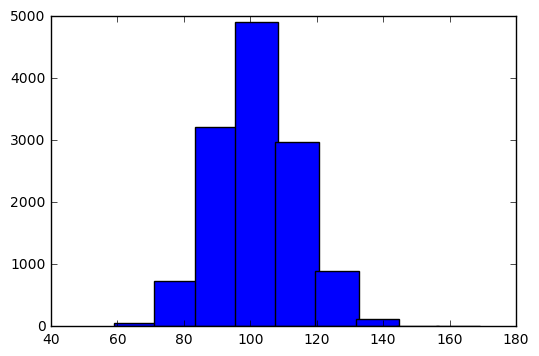

In [38]:
#Grafico del histograma
bar = plt.bar(mid_point_bins, counts, width=widths, color='b', align='edge')
plt.show()

In [39]:
sc.stop()

#### Bibliografia
* Statistical Data Exploration Using Spark by phtak-dev, https://github.com/phatak-dev/Statistical-Data-Exploration-Using-Spark-2.0/blob/master/jupyter/EDA%20on%20Life%20Expectancy%20Data.ipynb
(Informacion para Histograma)